# Fundamentals of Machine Learning (CSCI-UA.473)
## Lab 10: Clustering : K-means & Gaussian Mixtures


The goal of this lab is to practice implementing some basic clustering algorithms in sci-kit learn.  Specifically we will start with the K-Means algorithm and then move on to gaussian mixtures, introducing the Expectation Maximization (EM) algorithm

In [1]:
# Import the necessary packages from sci-kit learn
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import vq # Specifically uesful for K-means clustering
from sklearn import cluster  # Clustering algorithms such as K-means and agglomerative

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import MDS #Import the multidimensional scaling module
from scipy.spatial.distance import squareform #Import squareform, which creates a symmetric matrix from a vector
import time
import math
from sklearn import mixture
from scipy.stats import multivariate_normal as normal # Multivariate Gaussian distributions
from mpl_toolkits.axes_grid1 import ImageGrid

## K-means Clustering

We'll start by looking at the sci-kit learn implementation of K-means for a synthetic dataset that has distinct clusters.  The cell below generates a synthetic dataset with 4 well-separated clusters.

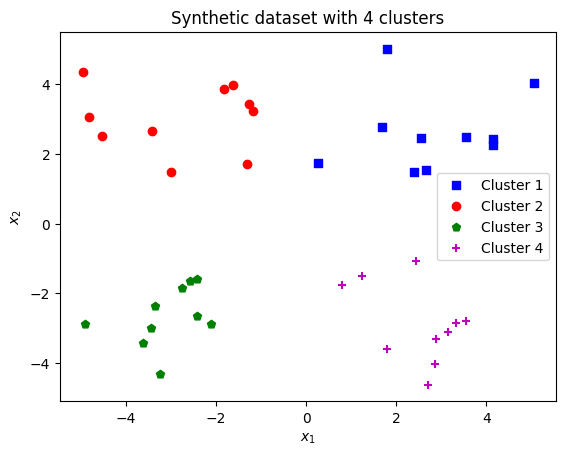

In [2]:
# Generate the synthetic dataset.
X1 = np.random.multivariate_normal(size = 10, mean = np.array([3, 3]), cov = np.identity(2))
X2 = np.random.multivariate_normal(size = 10, mean = np.array([-3, 3]), cov = np.identity(2))
X3 = np.random.multivariate_normal(size = 10, mean = np.array([-3, -3]), cov = np.identity(2))
X4 = np.random.multivariate_normal(size = 10, mean = np.array([3, -3]), cov = np.identity(2))

X = np.vstack([X1,X2,X3,X4])
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 's', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = 'o', label = 'Cluster 2')
plt.scatter(X3[:,0], X3[:,1], c = 'g', marker = 'p', label = 'Cluster 3')
plt.scatter(X4[:,0], X4[:,1], c = 'm', marker = '+', label = 'Cluster 4')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Synthetic dataset with 4 clusters')
plt.legend()
plt.show()

## Distortion

A key quantity in helping determine a good number of clusters to use is the distortion
$$
J = \sum_{i=1}^N \|{\bf x}_i - \mu_{C(i)}\|^2
$$
where ${\bf x}_i$ are the data points, $C(i) \in \{1,\ldots,K\}$ is the cluster assignment for ${\bf x}_i$ and $\mu_j$ for $j=1,\ldots,K$ are the centers of the clusters.  Intuitively, the distortion captures the unexplained variation in the dataset after accounting for the clusters.  If $K = N$, then $\mu_{C(i)} = {\bf x}_i$ and the distortion will be 0.  In this case there is a cluster at every data point so intuitively there is no unexplained variation.  However, having a large number of clusters is often not very useful since we will likely be overfitting to noise in the data.  There will often be a certain point where the distortion starts to decrease more slowly.  This is called the "elbow method", which is what we plot below.

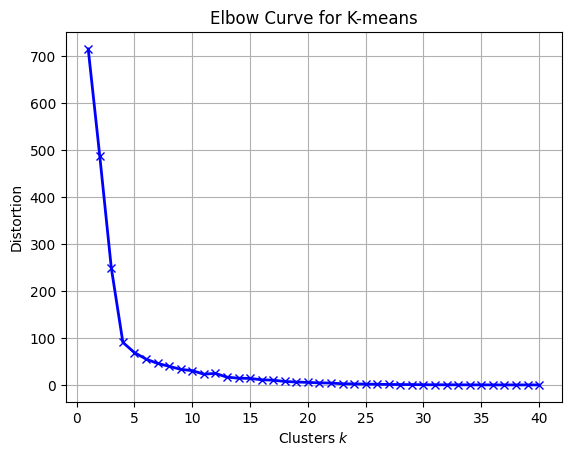

In [3]:
# Array to keep track of the distortions for K=1,...,N.
distortions = np.zeros(len(X))

for k in range(1, len(X) + 1):
    kmeans = cluster.KMeans(k, n_init="auto") # K-means object in sci-kit learn with k clusters.
    kmeans.fit(X)              # This is the line that actually runs the K-means algorithm.
    distortions[k-1] = kmeans.inertia_ # In sci-kit learn the distortion is called the inertia.

# Plot the results.
plt.plot(np.arange(1, len(X)+1, 1), distortions, 'b-x', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Distortion')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

Indeed we see from the plot above that the distortion decreases rapidly up until $k=4$, which was the true number of clusters for our data.  After this point we begin overfitting to the noise and the distortion will not decrease as much.  A general heuristic is to choose $k$ where the kink, or elbow, in the curve occurs.

## Exercise 1

This data was well-separated, however, let's see how the distortion behave whenever there is overlap between the clusters. Repeat the generation of the synthetic dataset with the clusters closer together. You can define means as {(1, 1), (-1, 1), (-1,-1), (1, -1)} and same covariance of 2 for all clusters. Plot the Elbow Curve again and comment on the results.

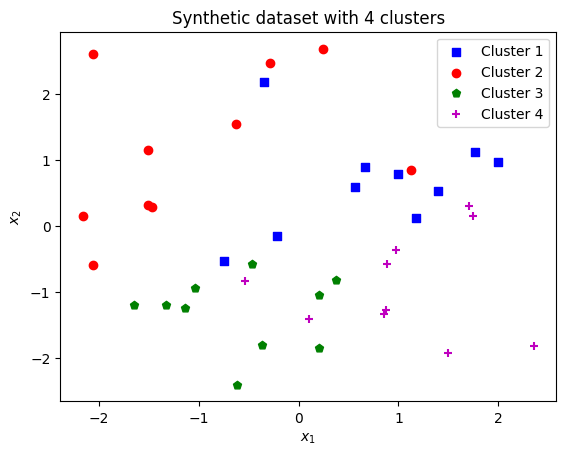

In [4]:
# Generate the new synthetic dataset.  The only difference from before is that the means are closer together now.
X1 = np.random.multivariate_normal(size = 10, mean = np.array([1, 1]), cov = np.identity(2))
X2 = np.random.multivariate_normal(size = 10, mean = np.array([-1, 1]), cov = np.identity(2))
X3 = np.random.multivariate_normal(size = 10, mean = np.array([-1, -1]), cov = np.identity(2))
X4 = np.random.multivariate_normal(size = 10, mean = np.array([1, -1]), cov = np.identity(2))

X = np.vstack([X1,X2,X3,X4])
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 's', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = 'o', label = 'Cluster 2')
plt.scatter(X3[:,0], X3[:,1], c = 'g', marker = 'p', label = 'Cluster 3')
plt.scatter(X4[:,0], X4[:,1], c = 'm', marker = '+', label = 'Cluster 4')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Synthetic dataset with 4 clusters')
plt.legend()
plt.show()

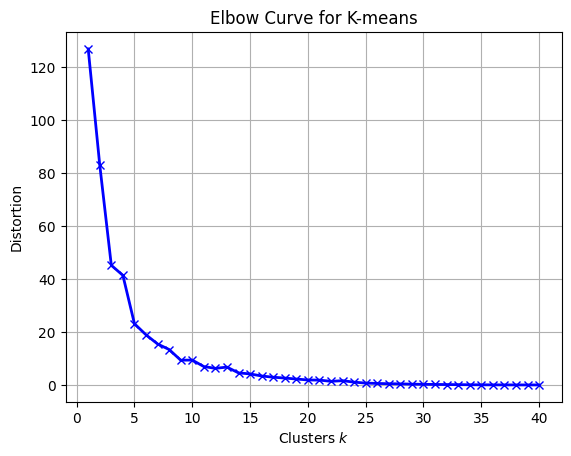

In [5]:
# Array of the distortions for k=1,...,N.
distortions = np.zeros(len(X))

# Same code as before.
for k in range(1, len(X) - 1):
    kmeans = cluster.KMeans(k, n_init='auto')
    kmeans.fit(X)
    distortions[k-1] = kmeans.inertia_

# Plot the results.
plt.plot(np.arange(1, len(X)+1, 1), distortions, 'b-x', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Distortion')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

Now there is a more gradual decrease in the distortion and it is not as clear what choice of $k$ one should use.  

# Silhoutte Scores

![](./Sscore.png)

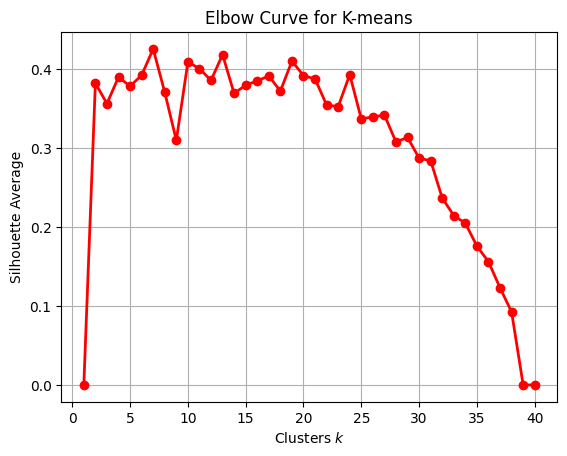

In [6]:
silhouettes = np.zeros(len(X))

# Same code as before.
for k in range(2, len(X) - 1):
    kmeans = cluster.KMeans(k, n_init='auto')
    labels = kmeans.fit_predict(X)
    silhouettes[k-1] = silhouette_score(X, labels)

plt.plot(np.arange(1, len(X)+1, 1), silhouettes, 'r-o', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Silhouette Average')
plt.title(r'Elbow Curve for K-means')
plt.grid()
plt.show()

## Initializing the Cluster Centers
One feature of K-means is that it is prone to becoming stuck in local minimum and is therefore sensitive to the initial cluster centers that are chosen.  The scipy implementation `kmeans2` allows for more flexibility in choosing the initial conditions so we also show it here as an alternative to sci-kit's implementation.  Now we see how the distortion changes after each iteration in K-means for different initializations.

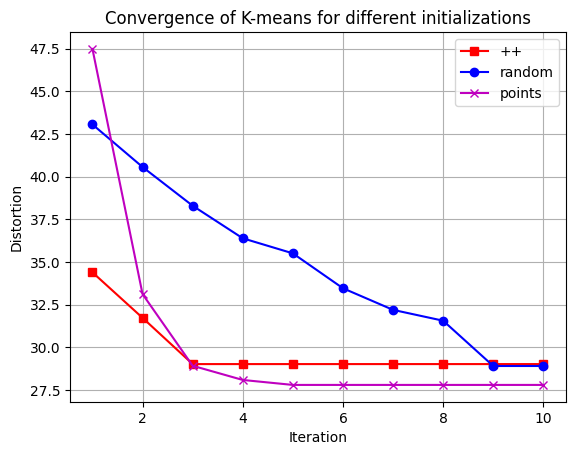

In [7]:
# Plot the distortion vs iteration for three different initial means.

# Helper function to compute the distortion using the data X and the computed cluster centers
# and labels for each point.
def distortion(X, centers, labels):
    N = X.shape[0]
    J = 0
    for i in range(N):
        J += np.linalg.norm(X[i] - centers[labels[i]])**2
    return J

# Only use 10 iterations of K-means.
max_iter = 10
distortions_1 = np.zeros(max_iter)
distortions_2 = np.zeros(max_iter)
distortions_3 = np.zeros(max_iter)

# 3 different initializations.
K = 4 # 4 clusters
np.random.seed(325) # Random seed is only chosen to emphasize difference between initializations.
                    # This line could be removed.
centers1, labels1 = vq.kmeans2(data = X, k = K, iter = 1, minit = '++')      # k-means++ initialization
centers2, labels2 = vq.kmeans2(data = X, k = K, iter = 1, minit = 'random')  # points sampled from a Gaussian
centers3, labels3 = vq.kmeans2(data = X, k = K, iter = 1, minit = 'points')  # points chosen from the dataset

distortions_1[0] = distortion(X, centers1, labels1)
distortions_2[0] = distortion(X, centers2, labels2)
distortions_3[0] = distortion(X, centers3, labels3)

for i in range(1, max_iter):
    # Do 1 iteration of K-means using the cluster centers from the last iteration.
    centers1, labels1 = vq.kmeans2(data = X, k = centers1, iter = 1, minit = 'matrix')
    centers2, labels2 = vq.kmeans2(data = X, k = centers2, iter = 1, minit = 'matrix')
    centers3, labels3 = vq.kmeans2(data = X, k = centers3, iter = 1, minit = 'matrix')

    distortions_1[i] = distortion(X, centers1, labels1)
    distortions_2[i] = distortion(X, centers2, labels2)
    distortions_3[i] = distortion(X, centers3, labels3)

# Plot the results
plt.plot(np.arange(1, max_iter + 1), distortions_1, 'r-s', label = '++')
plt.plot(np.arange(1, max_iter + 1), distortions_2, 'b-o', label = 'random')
plt.plot(np.arange(1, max_iter + 1), distortions_3, 'm-x', label = 'points')
plt.xlabel(r'Iteration')
plt.ylabel(r'Distortion')
plt.title(r'Convergence of K-means for different initializations')
plt.legend()
plt.grid()
plt.show()

The fact that all three curves have leveled-off indicates the K-means has converged.  However, the distortion is different meaning we have congevered to different local optima.

# K-Mediods Clustering <a class="anchor" id="second"></a>

The k-medoids algorithm is a clustering algorithm related to the k-means algorithm and the medoidshift algorithm. Both the k-means and k-medoids algorithms are partitional (breaking the dataset up into groups). K-means attempts to minimize the total squared error, while k-medoids minimizes the sum of dissimilarities between points labeled to be in a cluster and a point designated as the center of that cluster. In contrast to the k-means algorithm, k-medoids chooses datapoints as centers ( medoids or exemplars).

K-medoids is also a partitioning technique of clustering that clusters the data set of n objects into k clusters with k known a priori. A useful tool for determining k is the silhouette.

It could be more robust to noise and outliers as compared to k-means because it minimizes a sum of general pairwise dissimilarities instead of a sum of squared Euclidean distances. The possible choice of the dissimilarity function is very rich but in our applet we used the Euclidean distance.

A medoid of a finite dataset is a data point from this set, whose average dissimilarity to all the data points is minimal i.e. it is the most centrally located point in the set.

The most common realisation of k-medoid clustering is the Partitioning Around Medoids (PAM) algorithm and is as follows:

    * Initialize: randomly select k of the n data points as the medoids
    * Assignment step: Associate each data point to the closest medoid.
    * Update step: For each medoid m and each data point o associated to m swap m and o and compute the total cost of the configuration (that is, the average dissimilarity of o to all the data points associated to m). Select the medoid o with the lowest cost of the configuration.

Repeat alternating steps 2 and 3 until there is no change in the assignments.

In [8]:
#define distance metric
euclidean = lambda x1,x2: np.sqrt(np.sum((x1-x2)**2,-1))

class KMedoids:

    def __init__(self, K=5, max_iters=100, dist_fn=euclidean, repeats=10):
        self.K = K
        self.max_iters = max_iters                        #for computing each medoid
        self.dist_fn = dist_fn
        self.repeats = repeats                            #for several runs to compute medoids

    def fit(self, x):
        #note that medoids stores a list of K indices
        n,d = x.shape
        distances = self.dist_fn(x[None,:,:], x[:,None,:])       #distance function for pairwise distance [n, n]
        best_cost = np.inf
        for r in range(self.repeats):
        #we repeat the process of finding medoids for self.repeats time
            medoids = np.random.choice(n, self.K, replace=False)      #randomly choose a list of k distinct indices from 0 to n-1
            for t in range(self.max_iters):
                membership = np.argmin(distances[medoids,:], axis=0)       #assign membership based on distance from the medoids
                new_medoids = medoids.copy()
                cost = 0
                for i in range(self.K):
                    cluster_inds = np.nonzero(membership == i)[0]                                    #returns the indices of points with membership i
                    cluster_dist = np.sum(distances[np.ix_(cluster_inds, cluster_inds)], axis=1)     #pairwise distance between points with membership i and summed over axis 1
                    cost += np.min(cluster_dist)                                                     #compute the cost  for the
                    new_medoids[i] = cluster_inds[np.argmin(cluster_dist)]                           #find the index of i-th medoids
                if np.allclose(new_medoids, medoids):
                    #print(f'converged after {t} iterations with the cost {cost}')
                    break
                medoids = new_medoids
            if cost < best_cost:
                best_medoids = medoids
                best_membership = membership
        return best_medoids, best_membership

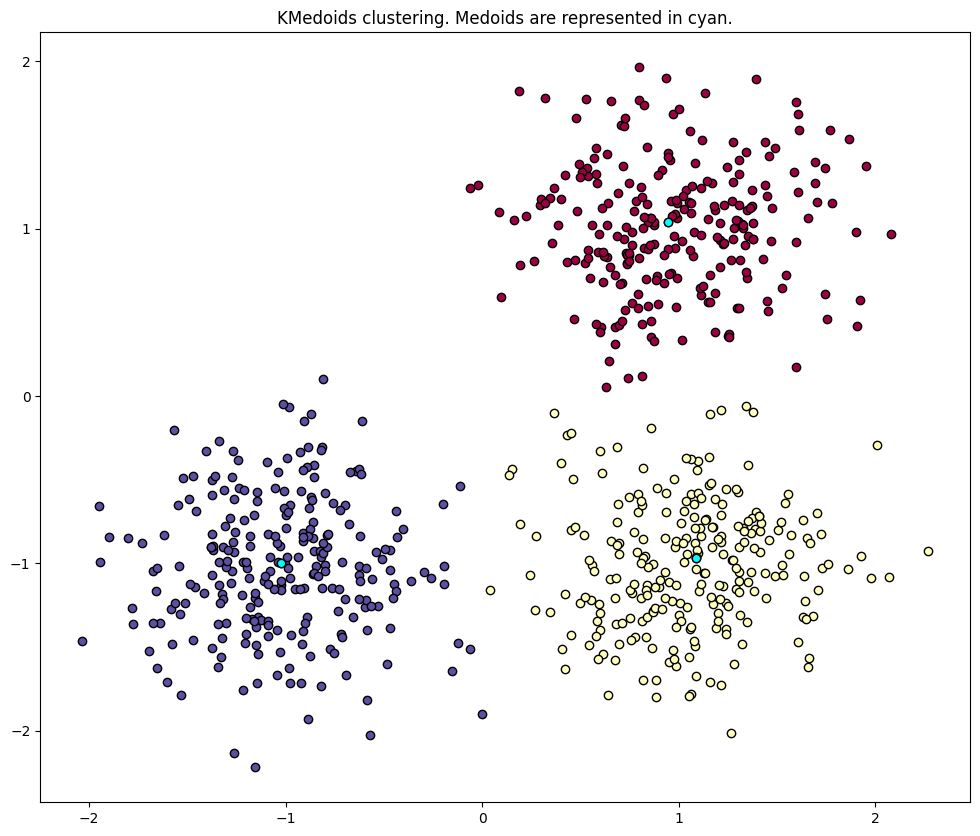

In [9]:
## K-Mediods Visualization
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = datasets.make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)
kmediods = KMedoids(K=3)
mediods, labels = kmediods.fit(X)
unique_labels = set(labels)
fig = plt.figure(figsize =(12, 10))
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = X[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
plt.plot(
    X[mediods][:, 0],
    X[mediods][:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")
plt.show()

Let's now repeat the application of K-mediods on the MNIST data set. We will load the data set from the sklearn library.

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


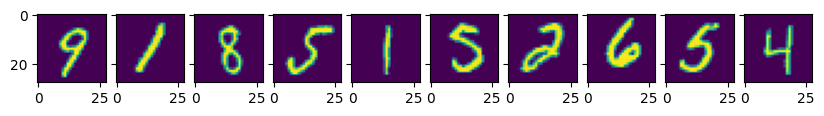

In [10]:
## Checking the representative digits that we get based on the dissimilarity measure used.
x_org, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
def plot_digits(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((28,28)))
    plt.show()


kmedoid = KMedoids(10, dist_fn=euclidean, repeats=2)
x = x_org.values[:1000]
centers, _ = kmedoid.fit(x.reshape(-1, 784))
plot_digits(x[centers])

## Exercise 2

Repeat the K-mediods algorithm for different distance functions defined as the **Manhattan** and **Hamming** distances. Compare the results with the Euclidean distance and each other.

Distance Function used:  euclidean


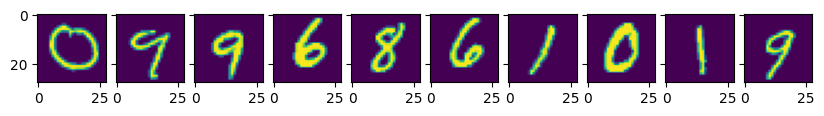

Distance Function used:  manhattan


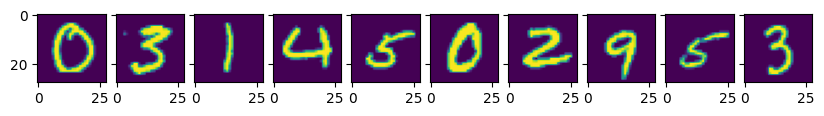

Distance Function used:  hamming


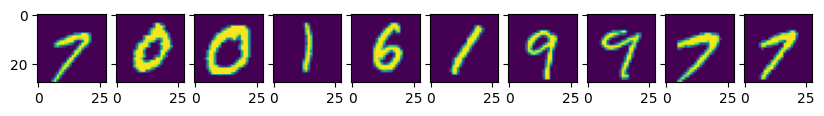

In [16]:
#define distance metric
euclidean = lambda x1,x2: np.sqrt(np.sum((x1-x2)**2,-1))
manhattan = lambda x1,x2: np.sum(np.abs(x1-x2), -1)
hamming = lambda x1,x2: np.sum((x1!=x2),-1)
dist_dict={"euclidean":euclidean, "manhattan":manhattan, "hamming":hamming}

x = x_org.values[:200]

for distance in dist_dict.keys():
    kmedoid = KMedoids(10, dist_fn=dist_dict[distance], repeats=2)
    centers, _ = kmedoid.fit(x.reshape(-1, 784))
    print("Distance Function used: ", distance)
    plot_digits(x[centers])

## Why to use KMediods over KMeans

Pros:
1. _K-medoid is more flexible_: First of all, you can use k-medoids with any similarity measure. K-means however, may fail to converge - it really must only be used with distances that are consistent with the mean. So e.g. Absolute Pearson Correlation must not be used with k-means, but it works well with k-medoids.

2. _Robustness of medoid_: Secondly, the medoid as used by k-medoids is roughly comparable to the median (in fact, there also is k-medians, which is like K-means but for Manhattan distance). If you look up literature on the median, you will see plenty of explanations and examples why the median is more robust to outliers than the arithmetic mean. Essentially, these explanations and examples will also hold for the medoid. It is a more robust estimate of a representative point than the mean as used in k-means.

Cons:
1. _k-medoids is much more expensive_: That's the main drawback. Usually, PAM takes much longer to run than k-means. As it involves computing all pairwise distances, it is O(n^2*k*i); whereas k-means runs in O(n*k*i) where usually, k times the number of iterations is k*i << n.

## Gaussian mixture models and the EM algorithm

One disadvantage of K-means is that the clusters are restricted to be spherical and so it is heavily dependent on the scaling of the features.  A Gaussian Mixture Model (GMMs) has an extra covariance parameter which allows us to represent poorly-scaled (i.e. long ellipses) data. In addition, GMMs also allow for soft clustering where any point could be contributing to multiple clusters.

Consider the following toy dataset generated from the Gaussian mixture model with parameters
$$
\phi = (0.5,\ 0.5),\quad \mu_0 = \begin{bmatrix}-3\\0\end{bmatrix},\quad \mu_1 = \begin{bmatrix}3\\0\end{bmatrix}
$$
and
$$
\Sigma_0 = \Sigma_1 = \begin{bmatrix}
1 & 0\\
0 & 100
\end{bmatrix}
$$
The dataset is plotted below.

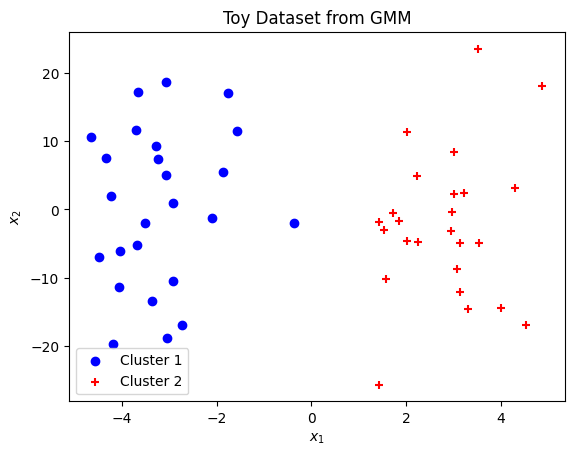

In [17]:
# Generate synthetic data
mu1 = np.array([-3, 0])
mu2 = np.array([3, 0])
Sigma = np.array([[1, 0], [0, 100]])
X1 = normal.rvs(mean = mu1, cov = Sigma, size = 25)
X2 = normal.rvs(mean = mu2, cov = Sigma, size = 25)

# Merge the data together.
X = np.vstack([X1, X2])

# Plot the data.
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 'o', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = '+', label = 'Cluster 2')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Toy Dataset from GMM')
plt.legend()
plt.show()

Now we'll fit a Gaussian mixture model to this data and plot the contours for the covariance as well as the locations of the means.

3 iterations for EM to converge.


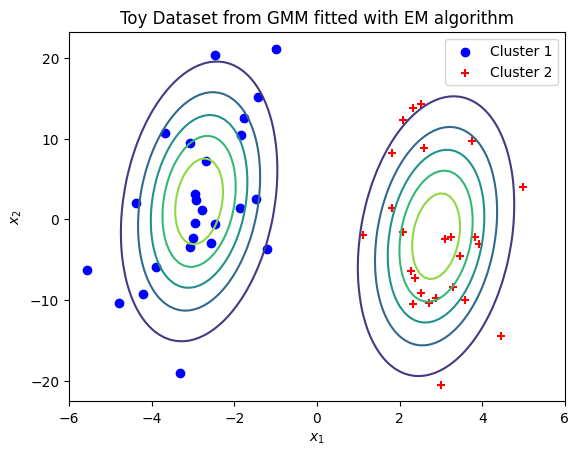

In [13]:
# Create the Gaussian mixture model object with 2 components.  The 'tied' argument refers to the fact that we
# specify the covariances of both components to be the same.  This constrains the problem and reduces the
# number of parameters we need to estimate.  We also provide the initial parameters which we happen to know already.
gmm = mixture.GaussianMixture(n_components = 2, covariance_type = 'tied', tol=1e-3, \
                              means_init = [mu1, mu2], precisions_init = np.linalg.inv(Sigma))

# The fit function uses the EM algorithm.
gmm.fit(X)

# Get the fitted means and covariances.
phi = gmm.weights_
mu = gmm.means_
cov = gmm.covariances_

# Can also get the number of iterations that was needed for convergence.
print("{:d} iterations for EM to converge.".format(gmm.n_iter_))

# Make a contour plot of the data.
xx = np.linspace(-6, 6, 100)
yy = np.linspace(-20, 20, 100)
XX, YY = np.meshgrid(xx, yy)
points = np.asarray([np.ravel(XX), np.ravel(YY)]).T
Z = phi[0]*normal.pdf(points, mean = mu[0], cov = cov) + phi[1]*normal.pdf(points, mean = mu[1], cov = cov)
ZZ = Z.reshape(XX.shape)

fig, ax = plt.subplots()
ax.contour(XX, YY, ZZ)
plt.scatter(X1[:,0], X1[:,1], c = 'b', marker = 'o', label = 'Cluster 1')
plt.scatter(X2[:,0], X2[:,1], c = 'r', marker = '+', label = 'Cluster 2')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Toy Dataset from GMM fitted with EM algorithm')
plt.legend()
plt.axis('tight')
plt.show()

## 3.  Other clustering algorithms

Both K-means and Gaussian mixture models can only fit elliptical clusters.  Sometimes data may have distinct clusters which do not fit this shape.  The following example is taken from the Sci-kit learn documentation [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html).

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-14-912b5cc82216>:127: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = algorithm.labels_.astype(np.int)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


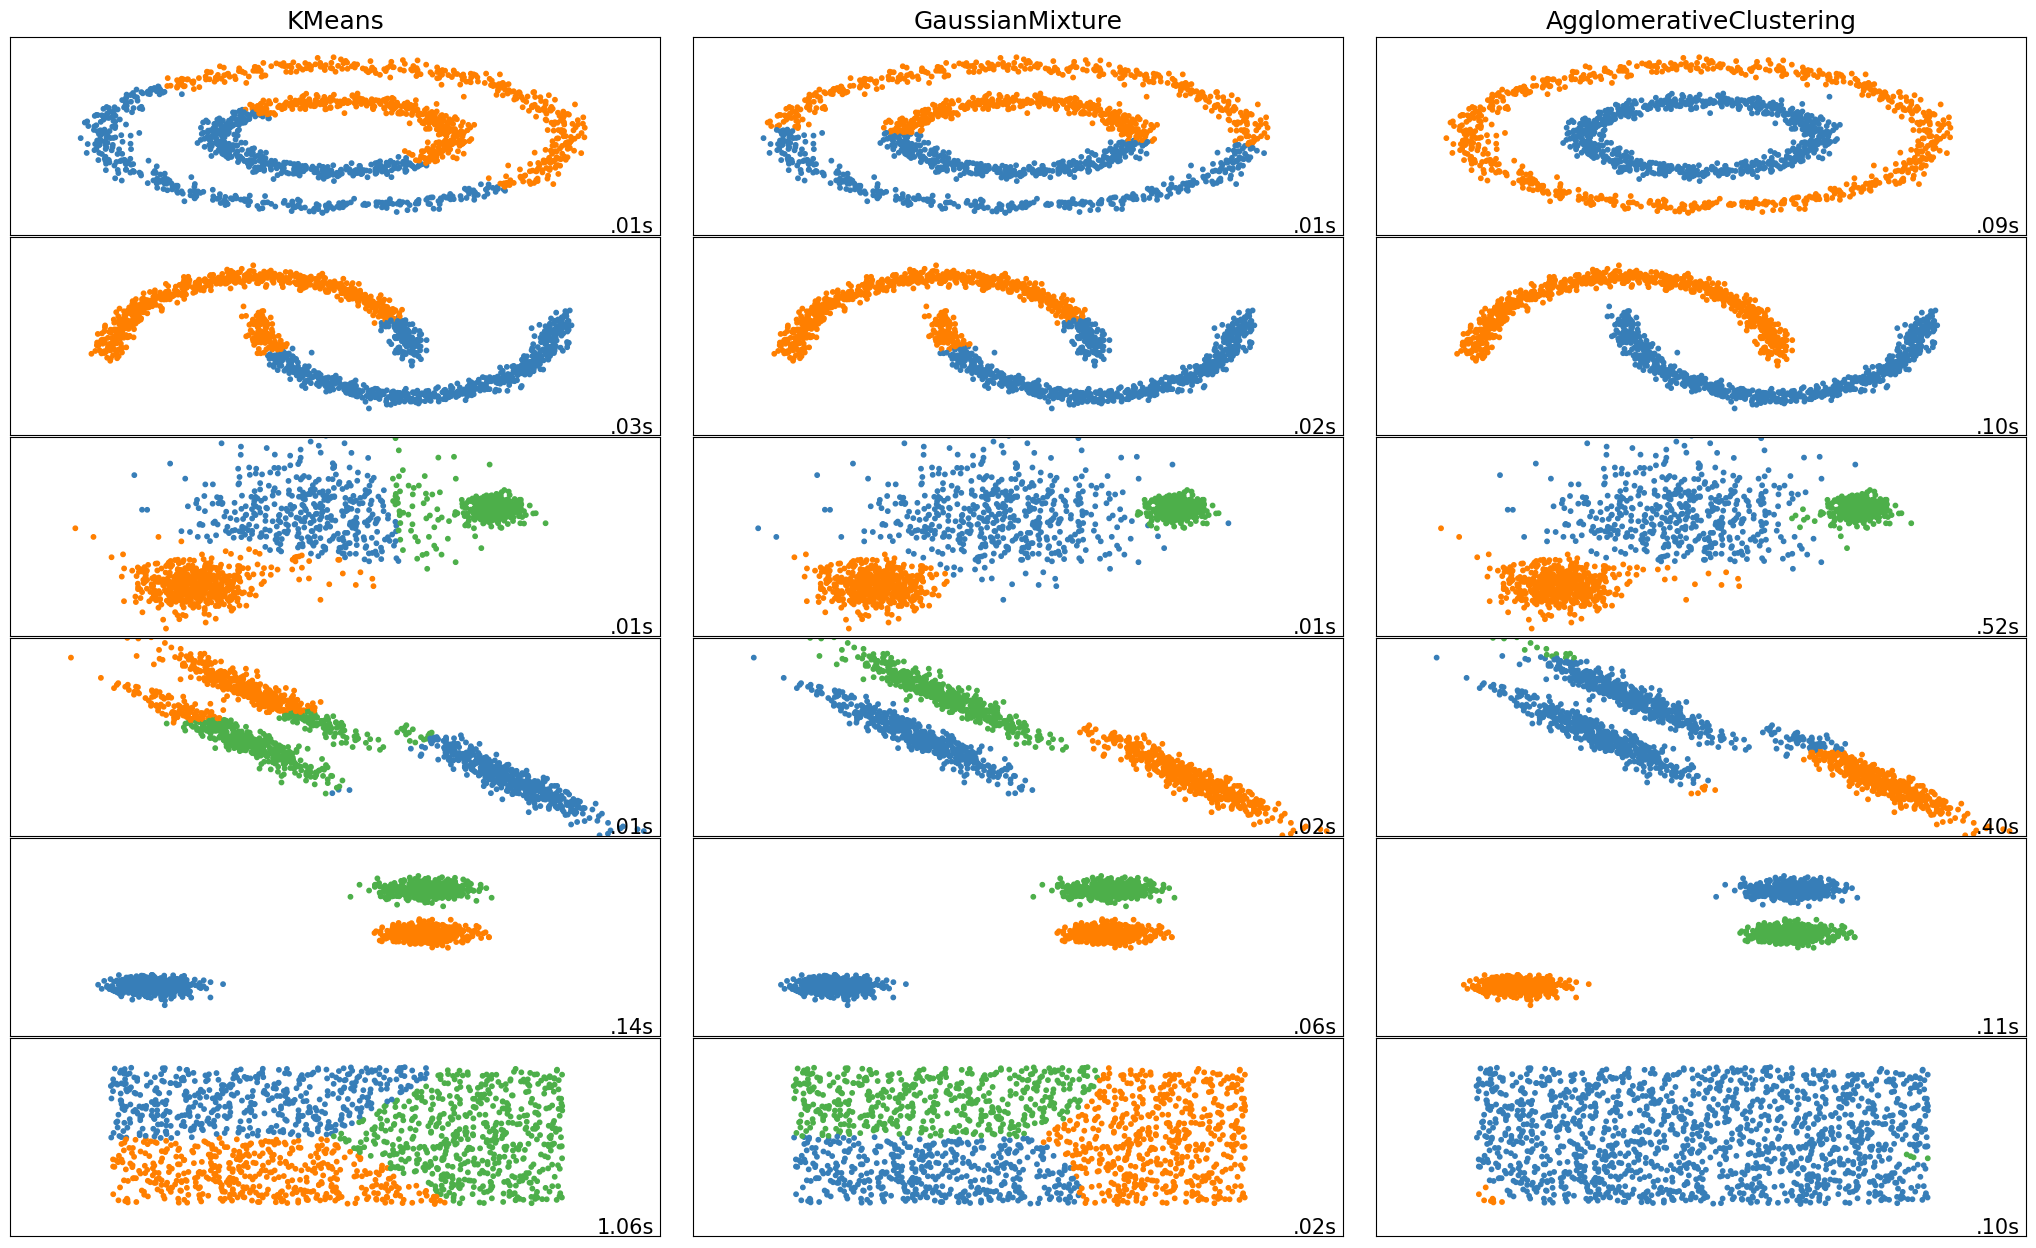

In [14]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph # kNN is needed for average linkage clustering
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

# Parameters for the datasets.
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============

    # K-Means algorithm.
    two_means = cluster.KMeans(n_clusters=params['n_clusters'])

    # Average linkage agglomerative clustering.
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)

    # Gaussian mixture model with EM algorithm.
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('KMeans', two_means),
        ('GaussianMixture', gmm),
        ('AgglomerativeClustering', average_linkage)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
plt.show()